In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('Food_Nutritional_Formulation.csv')

id_cols = ["food_product","Unnamed: 0"]
feature_cols = [c for c in df.columns if c not in id_cols]

df_products = df["food_product"].copy()

# remove non helpful features
df.drop(columns = id_cols,inplace=True)

df[feature_cols] = df[feature_cols].apply(pd.to_numeric, errors="coerce")

# remove all zero features
zero_cols = df.columns[(df == 0).all()]
df = df.drop(columns=zero_cols)

float_df = df.select_dtypes(float)
selector = VarianceThreshold(threshold=0.01)
selector.fit(float_df)

# remove low varaiance features
mask = selector.get_support()
removed_cols = float_df.columns[~mask]

df = df.drop(columns=removed_cols)

In [4]:
from sklearn.preprocessing import RobustScaler

# rescaling the datapoints given the mismatched measurements per feature
rescaler = RobustScaler()
rescaler.fit(df)
rescaler.transform(df)
df_rescaled = pd.DataFrame(rescaler.transform(df),columns=df.columns)

In [1]:
import umap.umap_ as umap
from sklearn.manifold import trustworthiness

# define a function that gets to maximize the trustworthiness of the n
def find_appropriate_n(data,nneigh,identity,mcompo=[25,65,100]):
  score = []
  embeddings = []
  for n in nneigh:
    print(f"- -- Params for {n} neighbors -- -")
    for m in mcompo:
      print(f">>> - -- Param for {m} components -- - <<<")
      reducer = umap.UMAP(n_neighbors=n,n_components=m,metric = "cosine")
      embedding = reducer.fit_transform(data)
      trustworthiness_score = trustworthiness(data,embedding)
      score.append(trustworthiness_score)
      embeddings.append(embedding)

      print(f"-> Trustworthiness Score: {trustworthiness_score}")
  umap_result = {
        "n": [n for n in nneigh for _ in mcompo],
        "m": mcompo * len(nneigh),
        "trustworthiness_score": score,
        "type": [identity]*len(score)
    }
  umap_result = pd.DataFrame(umap_result)

  best_index = umap_result["trustworthiness_score"].idxmax()
  max_embed = embeddings[best_index]
  max_n = umap_result.loc[best_index,"n"]
  max_m = umap_result.loc[best_index,"m"]
  max_tw_score = score[best_index]

  return max_n,max_embed,max_tw_score,max_m

In [28]:
import hdbscan
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import itertools

def optimize_hdbscan_param(embed, min_clust, min_samps, epsis):
    
    sil_scores = []
    cal_scores = []
    min_clusts = []
    min_samps_list = []
    epsises_list = []
    labels_list = []
    n_clusters_list = []
    n_outliers_list = []

    for min_cluster_size, min_samples, epsilon in itertools.product(min_clust, min_samps, epsis):
        clust = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            cluster_selection_epsilon=epsilon,
            approx_min_span_tree=True,
            core_dist_n_jobs=-1
        )
        pred_labels = clust.fit_predict(embed)
        
        unique_labels = set(pred_labels)
        n_clusters = len(unique_labels - {-1})
        n_outliers = list(pred_labels).count(-1)

        if n_clusters == 0:
            continue

        try:
            sil_score = silhouette_score(embed[pred_labels != -1], pred_labels[pred_labels != -1])
        except:
            sil_score = -1

        try:
            cal_score = calinski_harabasz_score(embed[pred_labels != -1], pred_labels[pred_labels != -1])
        except:
            cal_score = -1

        print(f"- --- - --- - --- - --- -")
        print(f"Min Cluster Size: {min_cluster_size}, Min Samples: {min_samples}, Epsilon: {epsilon}")
        print(f"Clusters: {n_clusters}, Outliers: {n_outliers}")
        print(f"Silhouette Score: {sil_score}, Calinski-Harabasz Score: {cal_score}")
        print(f"Ratio: {sil_score/cal_score if cal_score != 0 else 'NA'}")
        print(f"- --- - --- - --- - --- -\n")
        
        sil_scores.append(sil_score)
        cal_scores.append(cal_score)
        min_clusts.append(min_cluster_size)
        min_samps_list.append(min_samples)
        epsises_list.append(epsilon)
        labels_list.append(pred_labels)
        n_clusters_list.append(n_clusters)
        n_outliers_list.append(n_outliers)

    # Combine everything into a DataFrame
    hdbscan_param = pd.DataFrame({
        "min_cluster_size": min_clusts,
        "min_samples": min_samps_list,
        "cluster_selection_epsilon": epsises_list,
        "silhouette_score": sil_scores,
        "calinski_harabasz_score": cal_scores,
        "n_clusters": n_clusters_list,
        "n_outliers": n_outliers_list,
        "labels": labels_list
    })

    return hdbscan_param

In [6]:
sample_size = 10000
data_sampled = df_rescaled.sample(n=sample_size, random_state=42)

max_low_n,embed_low,tw_low,max_low_m = find_appropriate_n(data_sampled,[35,65,100],"Low N")
max_mid_n,embed_mid,tw_mid,max_mid_m = find_appropriate_n(data_sampled,[134,165,200],"Mid N")
max_high_n,embed_high,tw_high,max_high_m = find_appropriate_n(data_sampled,[230,265,300],"High N")

embeddings = [embed_low,embed_mid,embed_high]

n_s = [max_low_n,max_mid_n,max_high_n]
tw_s = [tw_low,tw_mid,tw_high]
identity = ["Low N","Mid N","High N"]
m_s = [max_low_m,max_mid_m,max_high_m]

nn_tw_param = {
    "n":n_s,
    "trustworthiness_score":tw_s,
    "type":identity,
    "m":m_s
}
nn_tw_param = pd.DataFrame(nn_tw_param)
nn_tw_param.sort_values(by="trustworthiness_score",ascending=False)

best_index = nn_tw_param["trustworthiness_score"].idxmax()
best_n = nn_tw_param.loc[best_index,"n"]
best_embed = embeddings[best_index]

- -- Params for 35 neighbors -- -
>>> - -- Param for 25 components -- - <<<
-> Trustworthiness Score: 0.9070540592473979
>>> - -- Param for 65 components -- - <<<
-> Trustworthiness Score: 0.9052565392313852
>>> - -- Param for 100 components -- - <<<
-> Trustworthiness Score: 0.9066771397117694
- -- Params for 65 neighbors -- -
>>> - -- Param for 25 components -- - <<<
-> Trustworthiness Score: 0.9034014451561249
>>> - -- Param for 65 components -- - <<<
-> Trustworthiness Score: 0.9022345356285029
>>> - -- Param for 100 components -- - <<<
-> Trustworthiness Score: 0.9024904463570856
- -- Params for 100 neighbors -- -
>>> - -- Param for 25 components -- - <<<
-> Trustworthiness Score: 0.9008029483586869
>>> - -- Param for 65 components -- - <<<
-> Trustworthiness Score: 0.9009537550040032
>>> - -- Param for 100 components -- - <<<
-> Trustworthiness Score: 0.9004581745396317
- -- Params for 134 neighbors -- -
>>> - -- Param for 25 components -- - <<<
-> Trustworthiness Score: 0.900007

In [33]:
nn_tw_param

,n,trustworthiness_score,type,m
0,35,0.907054,Low N,25
1,200,0.900788,Mid N,25
2,265,0.899892,High N,25


In [32]:
np.save("best_embed.npy", best_embed)

In [29]:
epsilons = [0,0.1,0.3,0.5,0.7]
min_clusters = [int(best_embed.shape[0]*0.01),int(best_embed.shape[0]*0.03), int(best_embed.shape[0]*0.05), int(best_embed.shape[0]*0.07), int(best_embed.shape[0]*0.1)]
min_samples = [int(best_embed.shape[0]*0.01*0.5),int(best_embed.shape[0]*0.03*0.5), int(best_embed.shape[0]*0.05*0.5), int(best_embed.shape[0]*0.07*0.5), int(best_embed.shape[0]*0.1*0.5)]

hdbscan_param = optimize_hdbscan_param(best_embed, min_clusters, min_samples, epsilons)

- --- - --- - --- - --- -
Min Cluster Size: 100, Min Samples: 50, Epsilon: 0
Clusters: 10, Outliers: 198
Silhouette Score: 0.5890934467315674, Calinski-Harabasz Score: 10134.398725703615
Ratio: 5.8128110278260986e-05
- --- - --- - --- - --- -

- --- - --- - --- - --- -
Min Cluster Size: 100, Min Samples: 50, Epsilon: 0.1
Clusters: 10, Outliers: 198
Silhouette Score: 0.5890934467315674, Calinski-Harabasz Score: 10134.398725703615
Ratio: 5.8128110278260986e-05
- --- - --- - --- - --- -

- --- - --- - --- - --- -
Min Cluster Size: 100, Min Samples: 50, Epsilon: 0.3
Clusters: 10, Outliers: 198
Silhouette Score: 0.5890934467315674, Calinski-Harabasz Score: 10134.398725703615
Ratio: 5.8128110278260986e-05
- --- - --- - --- - --- -

- --- - --- - --- - --- -
Min Cluster Size: 100, Min Samples: 50, Epsilon: 0.5
Clusters: 10, Outliers: 198
Silhouette Score: 0.5890934467315674, Calinski-Harabasz Score: 10134.398725703615
Ratio: 5.8128110278260986e-05
- --- - --- - --- - --- -

- --- - --- - --- 

In [30]:
hdbscan_param["outlier_ratio"] = best_params_df["n_outliers"] / sample_size
hdbscan_param

,min_cluster_size,min_samples,cluster_selection_epsilon,silhouette_score,calinski_harabasz_score,n_clusters,n_outliers,labels,outlier_ratio
0,100,50,0.0,0.589093,10134.398726,10,198,"[3, 8, 7, 3, 9, 6, 0, 7, 9, 7, 1, 7, 4, 6, 7, ...",0.1196
1,100,50,0.1,0.589093,10134.398726,10,198,"[3, 8, 7, 3, 9, 6, 0, 7, 9, 7, 1, 7, 4, 6, 7, ...",0.1196
2,100,50,0.3,0.589093,10134.398726,10,198,"[3, 8, 7, 3, 9, 6, 0, 7, 9, 7, 1, 7, 4, 6, 7, ...",0.1196
3,100,50,0.5,0.589093,10134.398726,10,198,"[3, 8, 7, 3, 9, 6, 0, 7, 9, 7, 1, 7, 4, 6, 7, ...",NaN
4,100,50,0.7,0.589093,10134.398726,10,198,"[3, 8, 7, 3, 9, 6, 0, 7, 9, 7, 1, 7, 4, 6, 7, ...",NaN
...,...,...,...,...,...,...,...,...,...
120,1000,500,0.0,0.530119,9802.284678,2,1123,"[0, 1, 1, 0, 1, 1, -1, 1, 1, 1, -1, 1, 0, 1, 1...",NaN
121,1000,500,0.1,0.530119,9802.284678,2,1123,"[0, 1, 1, 0, 1, 1, -1, 1, 1, 1, -1, 1, 0, 1, 1...",NaN
122,1000,500,0.3,0.530119,9802.284678,2,1123,"[0, 1, 1, 0, 1, 1, -1, 1, 1, 1, -1, 1, 0, 1, 1...",NaN
123,1000,500,0.5,0.530119,9802.284678,2,1123,"[0, 1, 1, 0, 1, 1, -1, 1, 1, 1, -1, 1, 0, 1, 1...",NaN


In [34]:
hdbscan_param_sort_sil = hdbscan_param.sort_values(by="silhouette_score", ascending=False)
hdbscan_param_sort_cal = hdbscan_param.sort_values(by="calinski_harabasz_score", ascending=False)
hdbscan_param_sort_outliers = hdbscan_param.sort_values(by="n_outliers", ascending=True)
hdbscan_param_sort_sil__cal = hdbscan_param.sort_values(by=["silhouette_score", "calinski_harabasz_score"], ascending=False)
hdbscan_param_sort_sil__cal__outliers = hdbscan_param.sort_values(by=["silhouette_score", "calinski_harabasz_score","n_outliers"], ascending=False)

In [35]:
hdbscan_param_sort_sil.head()

,min_cluster_size,min_samples,cluster_selection_epsilon,silhouette_score,calinski_harabasz_score,n_clusters,n_outliers,labels,outlier_ratio
74,500,500,0.7,0.695706,24576.902718,5,2107,"[1, -1, 4, 1, 3, -1, 0, 4, 3, 4, -1, 4, 2, -1,...",NaN
73,500,500,0.5,0.695706,24576.902718,5,2107,"[1, -1, 4, 1, 3, -1, 0, 4, 3, 4, -1, 4, 2, -1,...",NaN
24,100,500,0.7,0.695706,24576.902718,5,2107,"[1, -1, 4, 1, 3, -1, 0, 4, 3, 4, -1, 4, 2, -1,...",NaN
23,100,500,0.5,0.695706,24576.902718,5,2107,"[1, -1, 4, 1, 3, -1, 0, 4, 3, 4, -1, 4, 2, -1,...",NaN
22,100,500,0.3,0.695706,24576.902718,5,2107,"[1, -1, 4, 1, 3, -1, 0, 4, 3, 4, -1, 4, 2, -1,...",NaN


In [36]:
hdbscan_param_sort_cal.head()

,min_cluster_size,min_samples,cluster_selection_epsilon,silhouette_score,calinski_harabasz_score,n_clusters,n_outliers,labels,outlier_ratio
49,300,500,0.7,0.695706,24576.902718,5,2107,"[1, -1, 4, 1, 3, -1, 0, 4, 3, 4, -1, 4, 2, -1,...",NaN
72,500,500,0.3,0.695706,24576.902718,5,2107,"[1, -1, 4, 1, 3, -1, 0, 4, 3, 4, -1, 4, 2, -1,...",NaN
22,100,500,0.3,0.695706,24576.902718,5,2107,"[1, -1, 4, 1, 3, -1, 0, 4, 3, 4, -1, 4, 2, -1,...",NaN
23,100,500,0.5,0.695706,24576.902718,5,2107,"[1, -1, 4, 1, 3, -1, 0, 4, 3, 4, -1, 4, 2, -1,...",NaN
24,100,500,0.7,0.695706,24576.902718,5,2107,"[1, -1, 4, 1, 3, -1, 0, 4, 3, 4, -1, 4, 2, -1,...",NaN


In [37]:
hdbscan_param_sort_outliers.head()

,min_cluster_size,min_samples,cluster_selection_epsilon,silhouette_score,calinski_harabasz_score,n_clusters,n_outliers,labels,outlier_ratio
0,100,50,0.0,0.589093,10134.398726,10,198,"[3, 8, 7, 3, 9, 6, 0, 7, 9, 7, 1, 7, 4, 6, 7, ...",0.1196
1,100,50,0.1,0.589093,10134.398726,10,198,"[3, 8, 7, 3, 9, 6, 0, 7, 9, 7, 1, 7, 4, 6, 7, ...",0.1196
2,100,50,0.3,0.589093,10134.398726,10,198,"[3, 8, 7, 3, 9, 6, 0, 7, 9, 7, 1, 7, 4, 6, 7, ...",0.1196
3,100,50,0.5,0.589093,10134.398726,10,198,"[3, 8, 7, 3, 9, 6, 0, 7, 9, 7, 1, 7, 4, 6, 7, ...",NaN
4,100,50,0.7,0.589093,10134.398726,10,198,"[3, 8, 7, 3, 9, 6, 0, 7, 9, 7, 1, 7, 4, 6, 7, ...",NaN


In [38]:
hdbscan_param_sort_sil__cal.head()

,min_cluster_size,min_samples,cluster_selection_epsilon,silhouette_score,calinski_harabasz_score,n_clusters,n_outliers,labels,outlier_ratio
20,100,500,0.0,0.695706,24576.902718,5,2107,"[1, -1, 4, 1, 3, -1, 0, 4, 3, 4, -1, 4, 2, -1,...",NaN
21,100,500,0.1,0.695706,24576.902718,5,2107,"[1, -1, 4, 1, 3, -1, 0, 4, 3, 4, -1, 4, 2, -1,...",NaN
22,100,500,0.3,0.695706,24576.902718,5,2107,"[1, -1, 4, 1, 3, -1, 0, 4, 3, 4, -1, 4, 2, -1,...",NaN
23,100,500,0.5,0.695706,24576.902718,5,2107,"[1, -1, 4, 1, 3, -1, 0, 4, 3, 4, -1, 4, 2, -1,...",NaN
24,100,500,0.7,0.695706,24576.902718,5,2107,"[1, -1, 4, 1, 3, -1, 0, 4, 3, 4, -1, 4, 2, -1,...",NaN


In [39]:
hdbscan_param_sort_sil__cal__outliers.head()

,min_cluster_size,min_samples,cluster_selection_epsilon,silhouette_score,calinski_harabasz_score,n_clusters,n_outliers,labels,outlier_ratio
20,100,500,0.0,0.695706,24576.902718,5,2107,"[1, -1, 4, 1, 3, -1, 0, 4, 3, 4, -1, 4, 2, -1,...",NaN
21,100,500,0.1,0.695706,24576.902718,5,2107,"[1, -1, 4, 1, 3, -1, 0, 4, 3, 4, -1, 4, 2, -1,...",NaN
22,100,500,0.3,0.695706,24576.902718,5,2107,"[1, -1, 4, 1, 3, -1, 0, 4, 3, 4, -1, 4, 2, -1,...",NaN
23,100,500,0.5,0.695706,24576.902718,5,2107,"[1, -1, 4, 1, 3, -1, 0, 4, 3, 4, -1, 4, 2, -1,...",NaN
24,100,500,0.7,0.695706,24576.902718,5,2107,"[1, -1, 4, 1, 3, -1, 0, 4, 3, 4, -1, 4, 2, -1,...",NaN


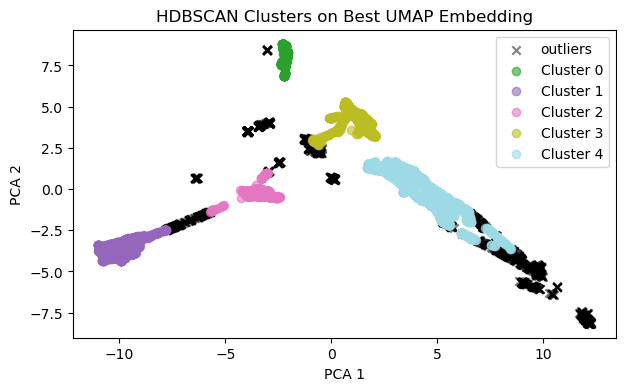

In [44]:
from sklearn.decomposition import PCA

embedding_2d = PCA(n_components=2).fit_transform(best_embed)
best_row = hdbscan_param.iloc[20]
best_labels = best_row['labels'] 

plt.figure(figsize=(7,4))
unique_labels = np.unique(best_labels)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    mask = best_labels == label
    if label == -1:
        plt.scatter(embedding_2d[mask, 0], embedding_2d[mask, 1], color='k', marker='x', alpha=0.5, label='outliers')
    else:
        plt.scatter(embedding_2d[mask, 0], embedding_2d[mask, 1], color=color, alpha=0.6, label=f'Cluster {label}')

plt.legend()
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("HDBSCAN Clusters on Best UMAP Embedding")
plt.show()

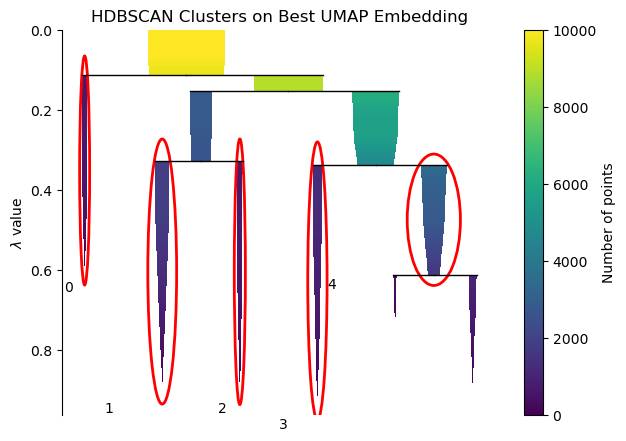

In [48]:
best_hdbscan = hdbscan.HDBSCAN(
    min_cluster_size=100,
    min_samples=500,
    cluster_selection_epsilon=0.0
)
best_labels = best_row['labels']
best_hdbscan.fit(best_embed) 

plt.figure(figsize=(7,5))
plt.title("HDBSCAN Clusters on Best UMAP Embedding")
best_hdbscan.condensed_tree_.plot(select_clusters=True, label_clusters=True)
plt.show()

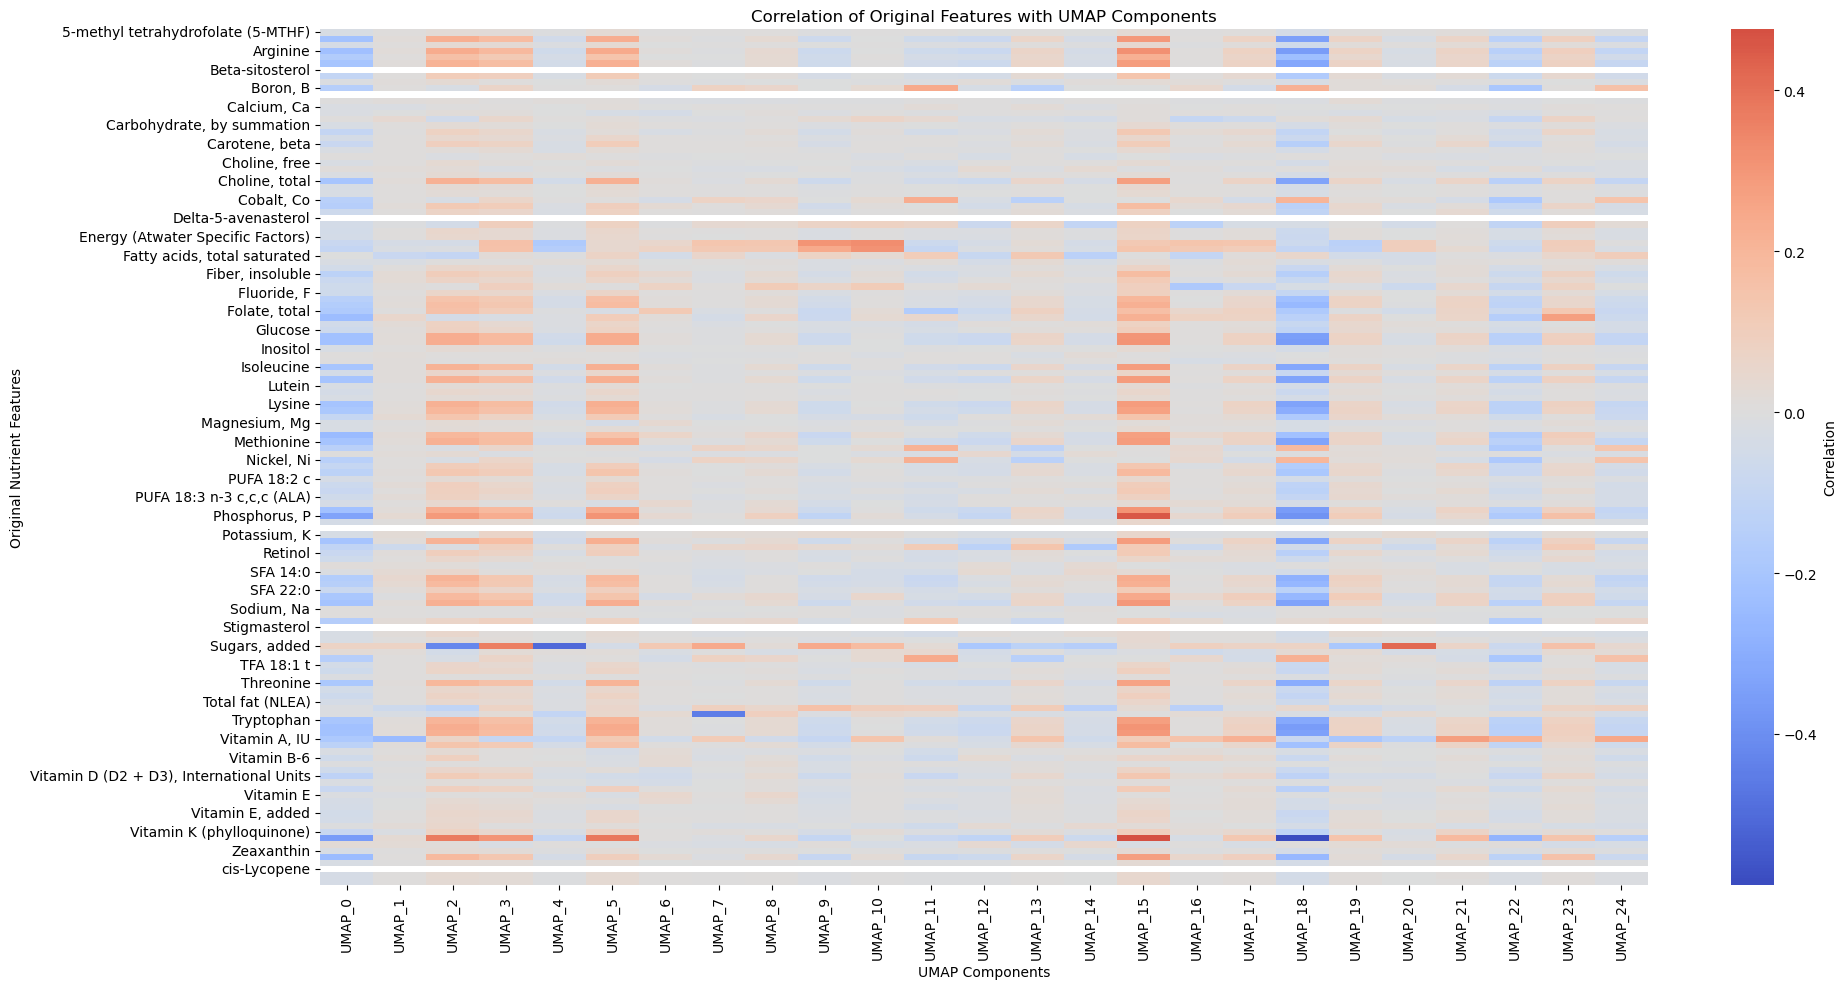

In [66]:
components_df = pd.DataFrame(best_embed, columns=[f"UMAP_{i}" for i in range(best_embed.shape[1])])

correlations = pd.DataFrame(
    np.corrcoef(data_sampled.T, components_df.T)[:data_sampled.shape[1], data_sampled.shape[1]:],
    index=data_sampled.columns,
    columns=components_df.columns
)

plt.figure(figsize=(20, 10))
sns.heatmap(correlations, cmap="coolwarm", center=0, annot=False, cbar_kws={'label': 'Correlation'})
plt.title("Correlation of Original Features with UMAP Components")
plt.xlabel("UMAP Components")
plt.ylabel("Original Nutrient Features")
plt.tight_layout()
plt.show()

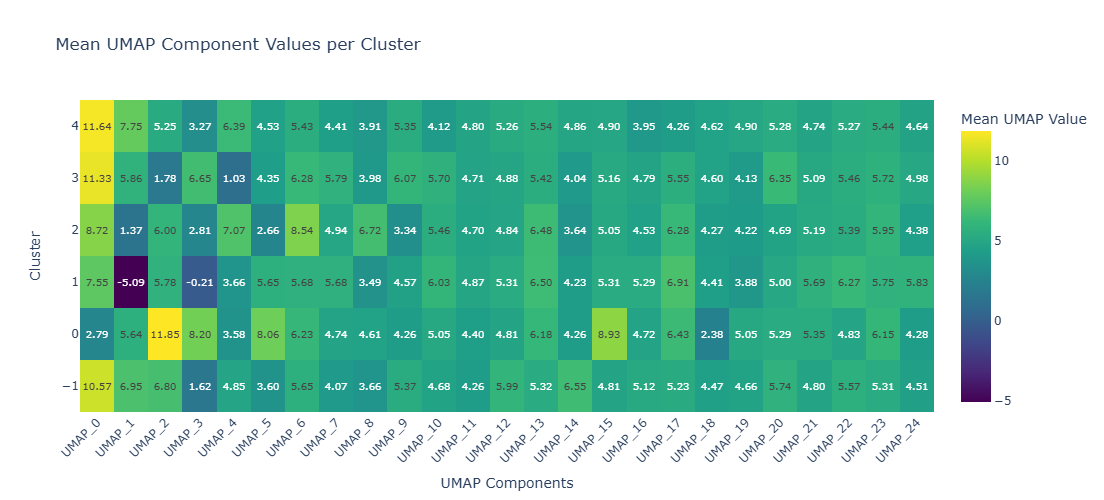

In [85]:
import plotly.graph_objects as go

cluster_means = df_embed_with_cluster.groupby('cluster').mean().sort_index()
z = cluster_means.values
text = np.round(z, 2)
fig = go.Figure(data=go.Heatmap(
    z=z,
    x=cluster_means.columns,
    y=cluster_means.index,
    colorscale='Viridis',
    colorbar=dict(title='Mean UMAP Value'),
    text=text,        
    texttemplate="%{text:.2f}",
    textfont={"size":10}
))

fig.update_layout(
    title="Mean UMAP Component Values per Cluster",
    xaxis_title="UMAP Components",
    yaxis_title="Cluster",
    xaxis_tickangle=-45,
    width=1000,
    height=500
)

fig.show()


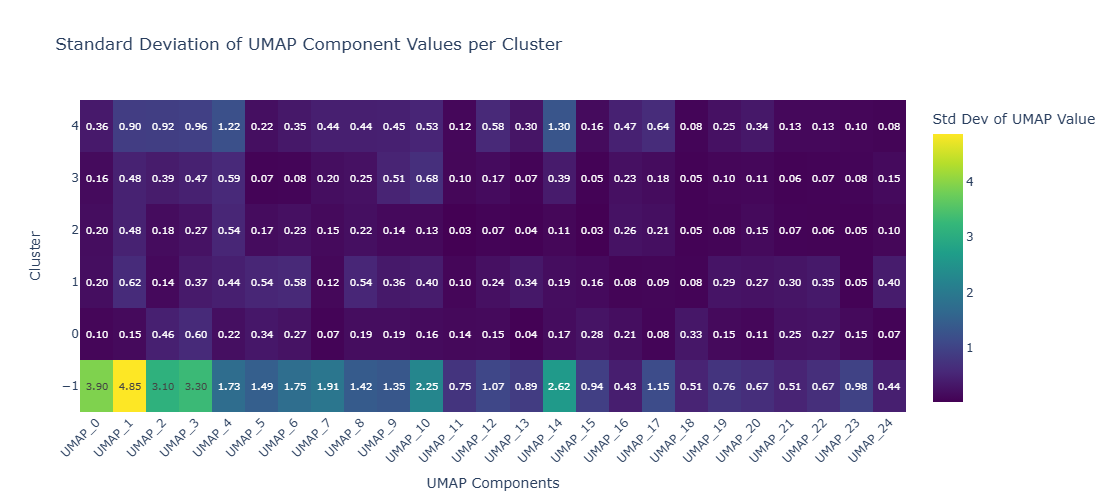

In [89]:
cluster_std = df_embed_with_cluster.groupby('cluster').std().sort_index()

z = cluster_std.values
text = np.round(z, 2)

fig = go.Figure(data=go.Heatmap(
    z=z,
    x=cluster_std.columns,
    y=cluster_std.index,
    colorscale='Viridis',
    colorbar=dict(title='Std Dev of UMAP Value'),
    text=text,
    texttemplate="%{text:.2f}",
    textfont={"size":10}
))

fig.update_layout(
    title="Standard Deviation of UMAP Component Values per Cluster",
    xaxis_title="UMAP Components",
    yaxis_title="Cluster",
    xaxis_tickangle=-45,
    width=1000,
    height=500
)

fig.show()


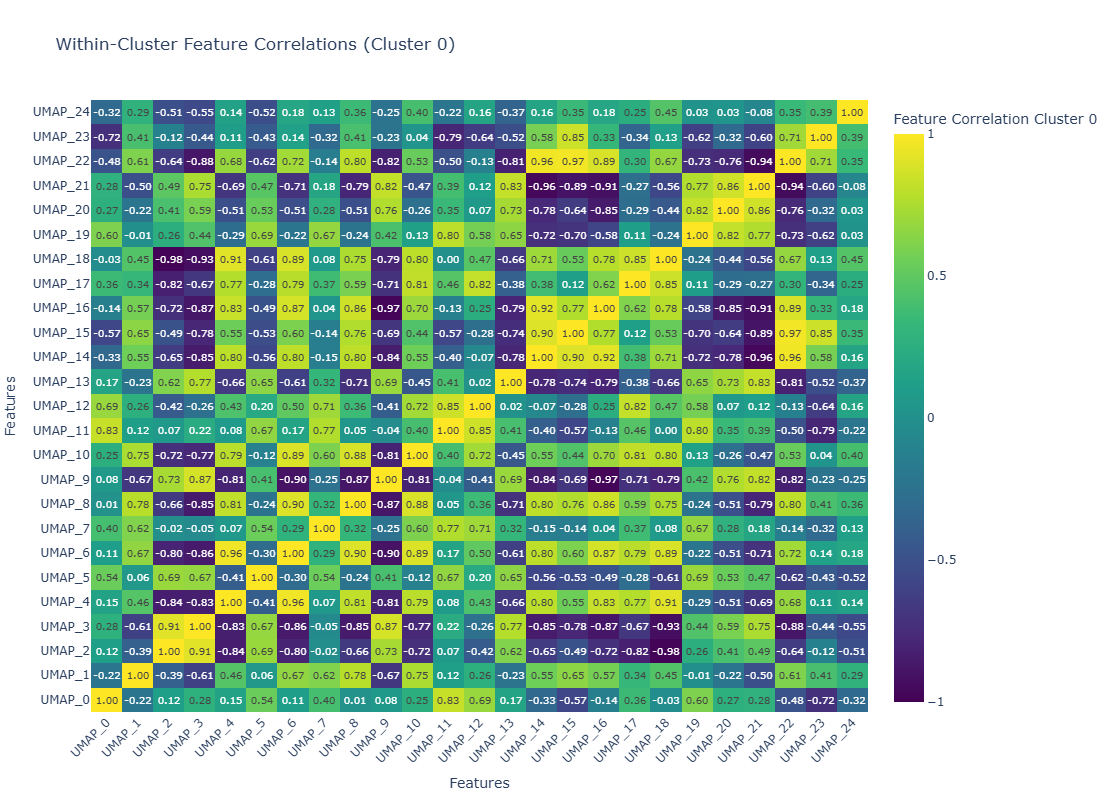

In [101]:
c = 0

cluster_data = df_embed_with_cluster[df_embed_with_cluster['cluster'] == c].drop('cluster', axis=1)
corr_matrix = cluster_data.corr()

z = corr_matrix.values
text = np.round(z, 2)

fig = go.Figure(data=go.Heatmap(
    z=z,
    x=corr_matrix.columns,
    y=corr_matrix.index,
    colorscale='Viridis',
    zmin=-1,
    zmax=1,
    colorbar=dict(title=f'Feature Correlation Cluster {c}'),
    text=text,
    texttemplate="%{text:.2f}",
    textfont={"size":10}
))

fig.update_layout(
    title=f"Within-Cluster Feature Correlations (Cluster {c})",
    xaxis_title="Features",
    yaxis_title="Features",
    xaxis_tickangle=-45,
    width=900,
    height=800
)

fig.show()

In [105]:
corr_pairs = (
    corr_matrix
    .stack()
    .reset_index()
    .rename(columns={'level_0': 'Feature1', 'level_1': 'Feature2', 0: 'Correlation'})
)
corr_pairs = corr_pairs[corr_pairs['Feature1'] != corr_pairs['Feature2']]

corr_pairs = corr_pairs[
    corr_pairs['Feature1'] < corr_pairs['Feature2']
]

corr_pairs['AbsCorr'] = corr_pairs['Correlation'].abs()
corr_pairs['Sign'] = corr_pairs['Correlation'].apply(lambda x: 'Positive' if x > 0 else 'Negative')

top10 = corr_pairs.sort_values('AbsCorr', ascending=False).head(10)
top10.drop(columns = ['AbsCorr'],inplace=True)
top10

,Feature1,Feature2,Correlation,Sign
452,UMAP_18,UMAP_2,-0.984448,Negative
409,UMAP_16,UMAP_9,-0.970237,Negative
397,UMAP_15,UMAP_22,0.966446,Positive
372,UMAP_14,UMAP_22,0.963340,Positive
106,UMAP_4,UMAP_6,0.959564,Positive
371,UMAP_14,UMAP_21,-0.957561,Negative
547,UMAP_21,UMAP_22,-0.938625,Negative
453,UMAP_18,UMAP_3,-0.926763,Negative
366,UMAP_14,UMAP_16,0.915908,Positive
421,UMAP_16,UMAP_21,-0.911770,Negative


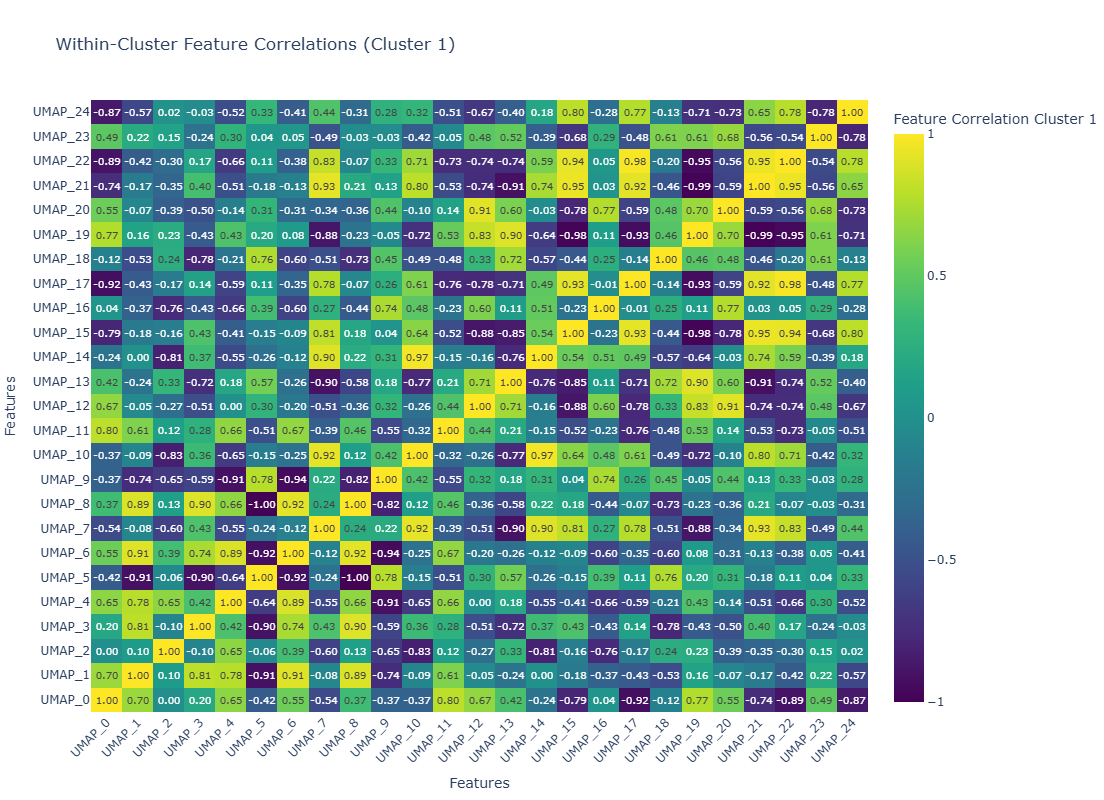

In [106]:
c = 1

cluster_data = df_embed_with_cluster[df_embed_with_cluster['cluster'] == c].drop('cluster', axis=1)
corr_matrix = cluster_data.corr()

z = corr_matrix.values
text = np.round(z, 2)

fig = go.Figure(data=go.Heatmap(
    z=z,
    x=corr_matrix.columns,
    y=corr_matrix.index,
    colorscale='Viridis',
    zmin=-1,
    zmax=1,
    colorbar=dict(title=f'Feature Correlation Cluster {c}'),
    text=text,
    texttemplate="%{text:.2f}",
    textfont={"size":10}
))

fig.update_layout(
    title=f"Within-Cluster Feature Correlations (Cluster {c})",
    xaxis_title="Features",
    yaxis_title="Features",
    xaxis_tickangle=-45,
    width=900,
    height=800
)

fig.show()

In [107]:
corr_pairs = (
    corr_matrix
    .stack()
    .reset_index()
    .rename(columns={'level_0': 'Feature1', 'level_1': 'Feature2', 0: 'Correlation'})
)
corr_pairs = corr_pairs[corr_pairs['Feature1'] != corr_pairs['Feature2']]

corr_pairs = corr_pairs[
    corr_pairs['Feature1'] < corr_pairs['Feature2']
]

corr_pairs['AbsCorr'] = corr_pairs['Correlation'].abs()
corr_pairs['Sign'] = corr_pairs['Correlation'].apply(lambda x: 'Positive' if x > 0 else 'Negative')

top10 = corr_pairs.sort_values('AbsCorr', ascending=False).head(10)
top10.drop(columns = ['AbsCorr'],inplace=True)
top10

,Feature1,Feature2,Correlation,Sign
133,UMAP_5,UMAP_8,-0.995003,Negative
496,UMAP_19,UMAP_21,-0.988607,Negative
394,UMAP_15,UMAP_19,-0.980145,Negative
447,UMAP_17,UMAP_22,0.979478,Positive
264,UMAP_10,UMAP_14,0.966625,Positive
547,UMAP_21,UMAP_22,0.948230,Positive
497,UMAP_19,UMAP_22,-0.947652,Negative
396,UMAP_15,UMAP_21,0.946221,Positive
159,UMAP_6,UMAP_9,-0.944394,Negative
397,UMAP_15,UMAP_22,0.936454,Positive


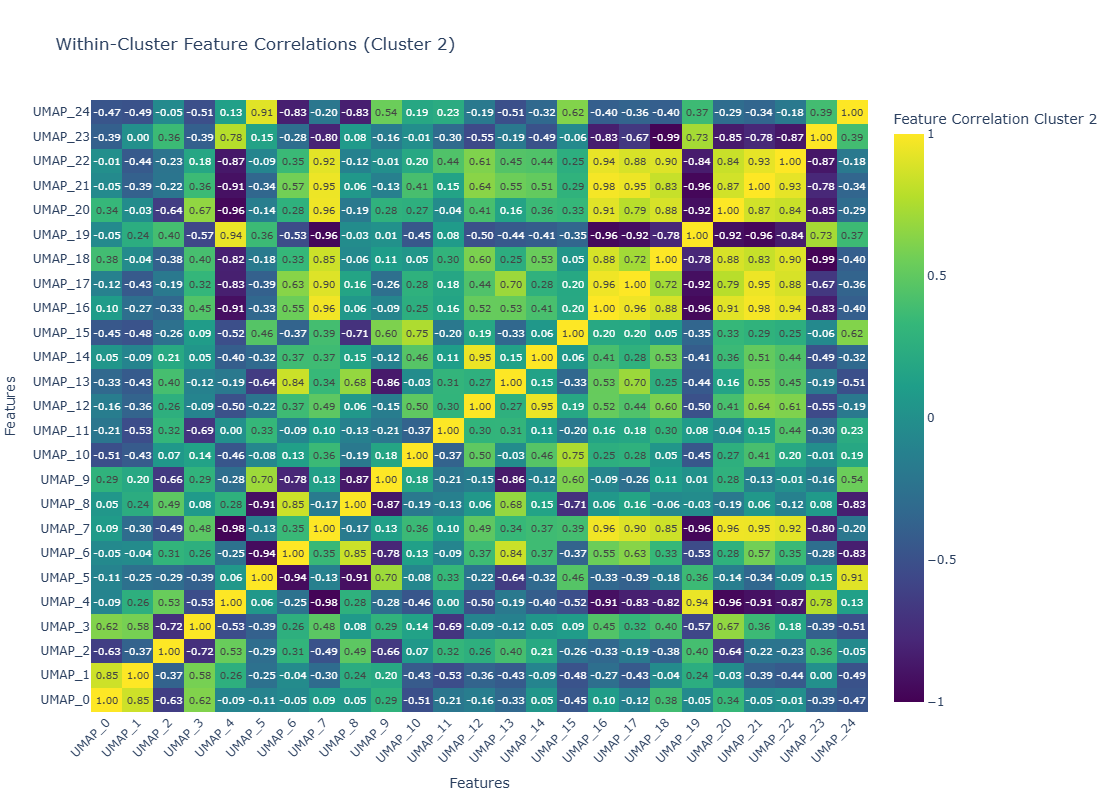

In [108]:
c = 2

cluster_data = df_embed_with_cluster[df_embed_with_cluster['cluster'] == c].drop('cluster', axis=1)
corr_matrix = cluster_data.corr()

z = corr_matrix.values
text = np.round(z, 2)

fig = go.Figure(data=go.Heatmap(
    z=z,
    x=corr_matrix.columns,
    y=corr_matrix.index,
    colorscale='Viridis',
    zmin=-1,
    zmax=1,
    colorbar=dict(title=f'Feature Correlation Cluster {c}'),
    text=text,
    texttemplate="%{text:.2f}",
    textfont={"size":10}
))

fig.update_layout(
    title=f"Within-Cluster Feature Correlations (Cluster {c})",
    xaxis_title="Features",
    yaxis_title="Features",
    xaxis_tickangle=-45,
    width=900,
    height=800
)

fig.show()

In [109]:
corr_pairs = (
    corr_matrix
    .stack()
    .reset_index()
    .rename(columns={'level_0': 'Feature1', 'level_1': 'Feature2', 0: 'Correlation'})
)
corr_pairs = corr_pairs[corr_pairs['Feature1'] != corr_pairs['Feature2']]

corr_pairs = corr_pairs[
    corr_pairs['Feature1'] < corr_pairs['Feature2']
]

corr_pairs['AbsCorr'] = corr_pairs['Correlation'].abs()
corr_pairs['Sign'] = corr_pairs['Correlation'].apply(lambda x: 'Positive' if x > 0 else 'Negative')

top10 = corr_pairs.sort_values('AbsCorr', ascending=False).head(10)
top10.drop(columns = ['AbsCorr'],inplace=True)
top10

,Feature1,Feature2,Correlation,Sign
473,UMAP_18,UMAP_23,-0.985396,Negative
107,UMAP_4,UMAP_7,-0.979656,Negative
421,UMAP_16,UMAP_21,0.975627,Positive
496,UMAP_19,UMAP_21,-0.964052,Negative
482,UMAP_19,UMAP_7,-0.963180,Negative
407,UMAP_16,UMAP_7,0.962679,Positive
504,UMAP_20,UMAP_4,-0.962348,Negative
417,UMAP_16,UMAP_17,0.957329,Positive
419,UMAP_16,UMAP_19,-0.956616,Negative
507,UMAP_20,UMAP_7,0.956428,Positive


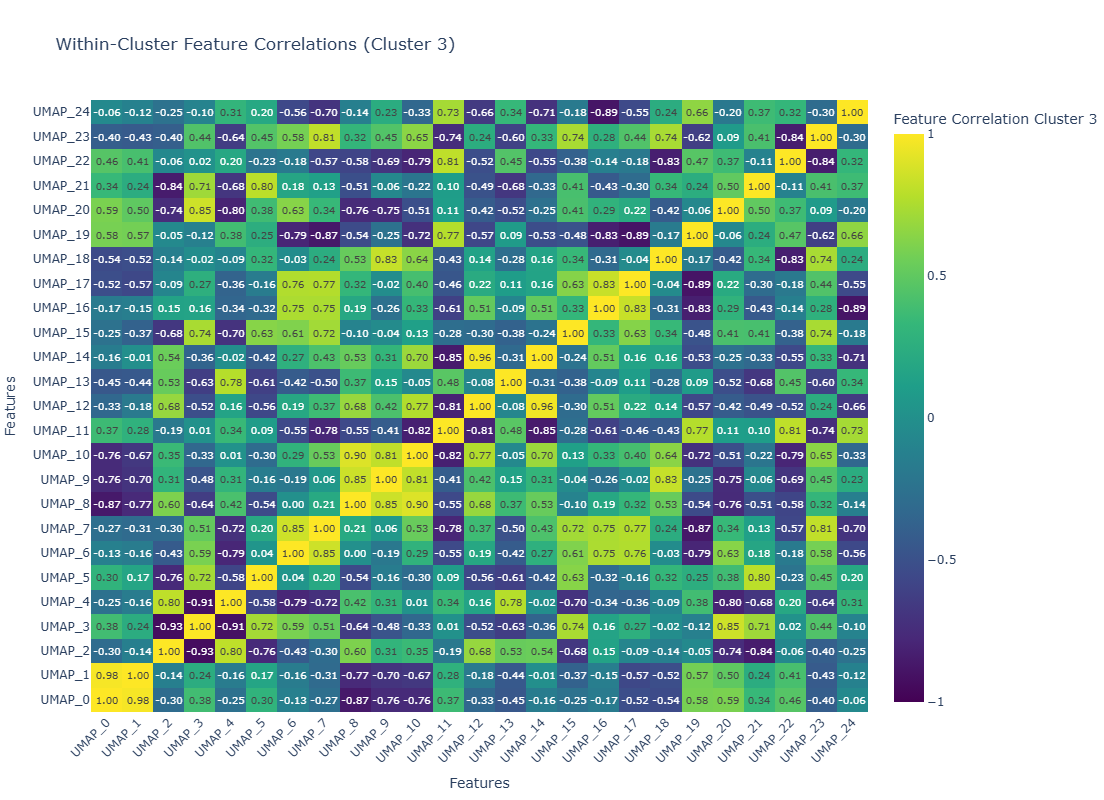

In [112]:
c = 3

cluster_data = df_embed_with_cluster[df_embed_with_cluster['cluster'] == c].drop('cluster', axis=1)
corr_matrix = cluster_data.corr()

z = corr_matrix.values
text = np.round(z, 2)

fig = go.Figure(data=go.Heatmap(
    z=z,
    x=corr_matrix.columns,
    y=corr_matrix.index,
    colorscale='Viridis',
    zmin=-1,
    zmax=1,
    colorbar=dict(title=f'Feature Correlation Cluster {c}'),
    text=text,
    texttemplate="%{text:.2f}",
    textfont={"size":10}
))

fig.update_layout(
    title=f"Within-Cluster Feature Correlations (Cluster {c})",
    xaxis_title="Features",
    yaxis_title="Features",
    xaxis_tickangle=-45,
    width=900,
    height=800
)

fig.show()

In [113]:
corr_pairs = (
    corr_matrix
    .stack()
    .reset_index()
    .rename(columns={'level_0': 'Feature1', 'level_1': 'Feature2', 0: 'Correlation'})
)
corr_pairs = corr_pairs[corr_pairs['Feature1'] != corr_pairs['Feature2']]

corr_pairs = corr_pairs[
    corr_pairs['Feature1'] < corr_pairs['Feature2']
]

corr_pairs['AbsCorr'] = corr_pairs['Correlation'].abs()
corr_pairs['Sign'] = corr_pairs['Correlation'].apply(lambda x: 'Positive' if x > 0 else 'Negative')

top10 = corr_pairs.sort_values('AbsCorr', ascending=False).head(10)
top10.drop(columns = ['AbsCorr'],inplace=True)
top10

,Feature1,Feature2,Correlation,Sign
1,UMAP_0,UMAP_1,0.978990,Positive
314,UMAP_12,UMAP_14,0.964804,Positive
53,UMAP_2,UMAP_3,-0.931752,Negative
79,UMAP_3,UMAP_4,-0.906477,Negative
258,UMAP_10,UMAP_8,0.896834,Positive
444,UMAP_17,UMAP_19,-0.888904,Negative
424,UMAP_16,UMAP_24,-0.886071,Negative
482,UMAP_19,UMAP_7,-0.870922,Negative
8,UMAP_0,UMAP_8,-0.865624,Negative
289,UMAP_11,UMAP_14,-0.853736,Negative


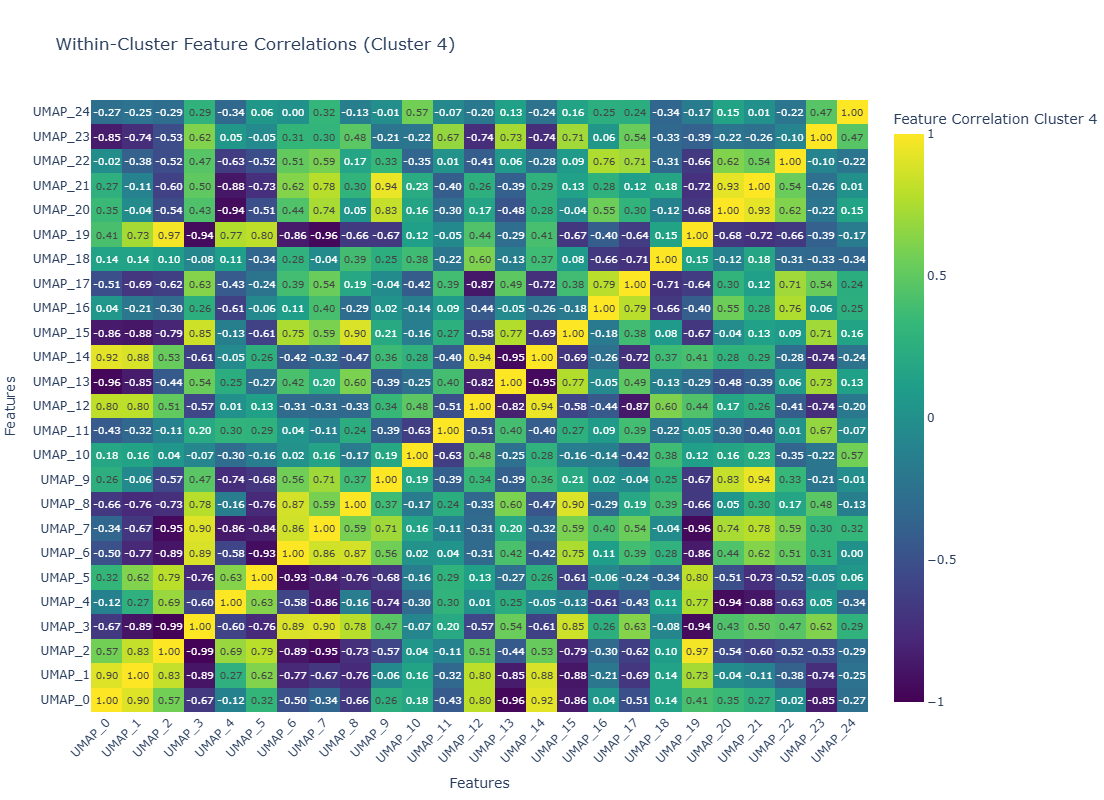

In [114]:
c = 4

cluster_data = df_embed_with_cluster[df_embed_with_cluster['cluster'] == c].drop('cluster', axis=1)
corr_matrix = cluster_data.corr()

z = corr_matrix.values
text = np.round(z, 2)

fig = go.Figure(data=go.Heatmap(
    z=z,
    x=corr_matrix.columns,
    y=corr_matrix.index,
    colorscale='Viridis',
    zmin=-1,
    zmax=1,
    colorbar=dict(title=f'Feature Correlation Cluster {c}'),
    text=text,
    texttemplate="%{text:.2f}",
    textfont={"size":10}
))

fig.update_layout(
    title=f"Within-Cluster Feature Correlations (Cluster {c})",
    xaxis_title="Features",
    yaxis_title="Features",
    xaxis_tickangle=-45,
    width=900,
    height=800
)

fig.show()

In [115]:
corr_pairs = (
    corr_matrix
    .stack()
    .reset_index()
    .rename(columns={'level_0': 'Feature1', 'level_1': 'Feature2', 0: 'Correlation'})
)
corr_pairs = corr_pairs[corr_pairs['Feature1'] != corr_pairs['Feature2']]

corr_pairs = corr_pairs[
    corr_pairs['Feature1'] < corr_pairs['Feature2']
]

corr_pairs['AbsCorr'] = corr_pairs['Correlation'].abs()
corr_pairs['Sign'] = corr_pairs['Correlation'].apply(lambda x: 'Positive' if x > 0 else 'Negative')

top10 = corr_pairs.sort_values('AbsCorr', ascending=False).head(10)
top10.drop(columns = ['AbsCorr'],inplace=True)
top10

,Feature1,Feature2,Correlation,Sign
53,UMAP_2,UMAP_3,-0.989915,Negative
477,UMAP_19,UMAP_2,0.971444,Positive
13,UMAP_0,UMAP_13,-0.964877,Negative
482,UMAP_19,UMAP_7,-0.956951,Negative
57,UMAP_2,UMAP_7,-0.946696,Negative
339,UMAP_13,UMAP_14,-0.946547,Negative
504,UMAP_20,UMAP_4,-0.943527,Negative
314,UMAP_12,UMAP_14,0.942781,Positive
534,UMAP_21,UMAP_9,0.940354,Positive
478,UMAP_19,UMAP_3,-0.936163,Negative
